In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
import sys
sys.path.append('../src/utils')

# Core
from utils_functions import *
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.simplefilter('ignore')

In [4]:
# Lectura de los datos
X = pd.read_csv('../data/processed/data_processed.csv', index_col=['country'])
X.sample(5, random_state=777)

,child_mort,exports,health,imports,income,inflation
country,,,,,,
Bangladesh,0.56,-1.18,-1.32,-1.26,-1.09,0.20
Bhutan,0.39,0.27,-0.53,1.18,-0.28,0.03
Malta,-0.93,2.07,0.75,2.27,0.96,-0.33
Tonga,-0.40,-1.46,-0.59,0.76,-0.49,-0.36
Italy,-1.14,-0.59,1.03,-0.90,1.17,-1.13


### PCA

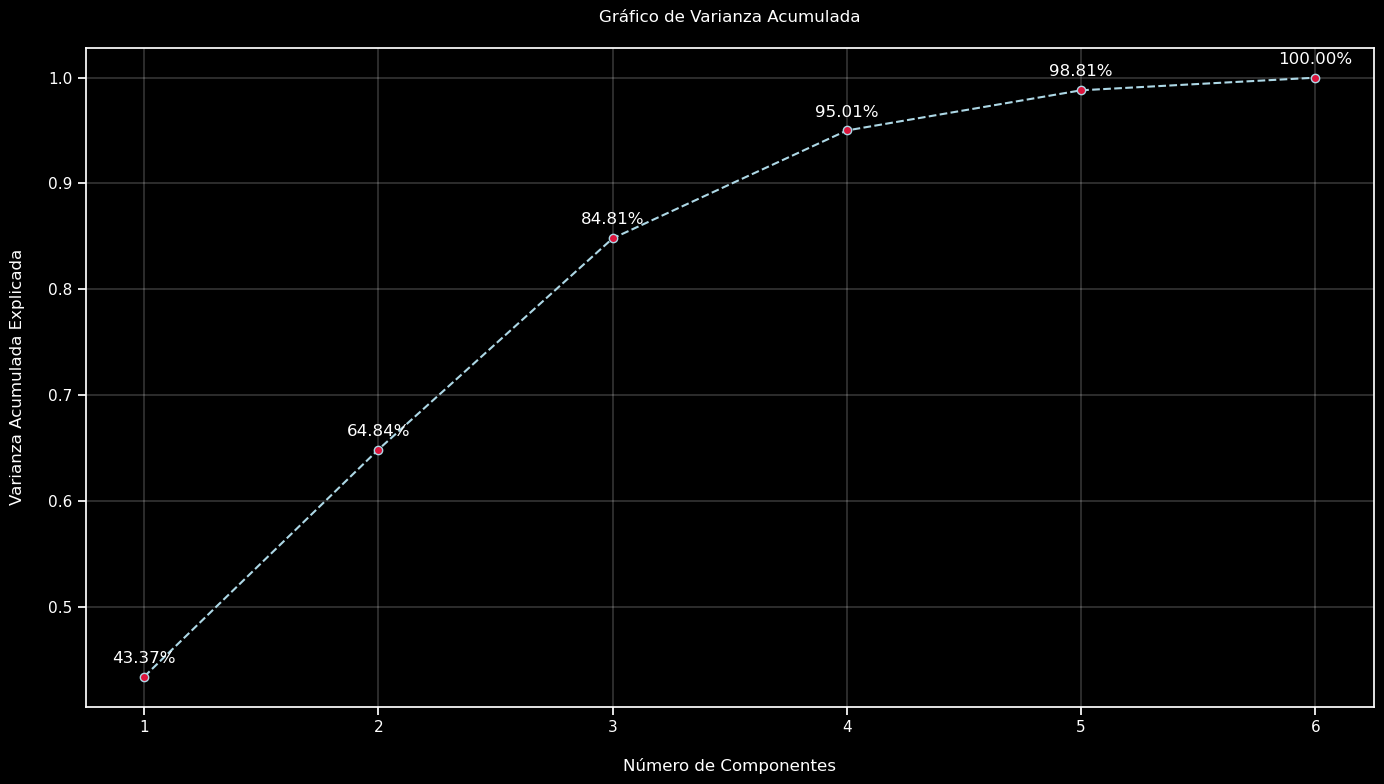

In [5]:
from sklearn.decomposition import PCA

# Realiza PCA
pca = PCA().fit(X)

# Gráfico de Varianza Acumulada
variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(14, 8))
plt.plot(range(1, len(variance_ratio_cumsum) + 1), variance_ratio_cumsum, marker='o',
         linestyle='--', markerfacecolor='crimson', c='lightblue')
plt.xlabel('\nNúmero de Componentes')
plt.ylabel('Varianza Acumulada Explicada\n')
plt.title('Gráfico de Varianza Acumulada\n')
plt.xticks(range(1, len(variance_ratio_cumsum) + 1))
plt.grid(color='white', linestyle='-', linewidth=0.25)

# Agregar etiquetas con valores de varianza
for i in range(len(variance_ratio_cumsum)):
    plt.annotate(f'{variance_ratio_cumsum[i]*100:.2f}%', (i + 1, variance_ratio_cumsum[i]), 
                 textcoords='offset points', xytext=(0, 10), ha='center')
plt.tight_layout()
plt.show()

In [6]:
# Crea un DataFrame para mostrar los resultados
resultados = pd.DataFrame({'Variable': X.columns, 
                           'Varianza Explicada': pca.explained_variance_ratio_})
resultados

,Variable,Varianza Explicada
0,child_mort,0.43
1,exports,0.21
2,health,0.20
3,imports,0.10
4,income,0.04
5,inflation,0.01


In [7]:
# Reducimos la dimensionalidad de nuestros datos
pca = PCA(n_components=4)
X_pca = pd.DataFrame(pca.fit_transform(X), columns=X.columns[:4], index=X.index) 
X_pca

,child_mort,exports,health,imports
country,,,,
Afghanistan,2.26,0.17,1.30,-0.27
Albania,-0.24,0.26,0.17,0.16
Algeria,0.67,-0.12,-1.60,-0.34
Angola,1.79,-2.11,-1.57,-0.50
Antigua and Barbuda,-1.35,-0.25,0.03,0.53
...,...,...,...,...
Vanuatu,0.06,-0.87,0.41,0.68
Venezuela,1.07,0.91,-2.17,-0.97
Vietnam,-0.59,-1.87,0.19,-1.09


### K-Means

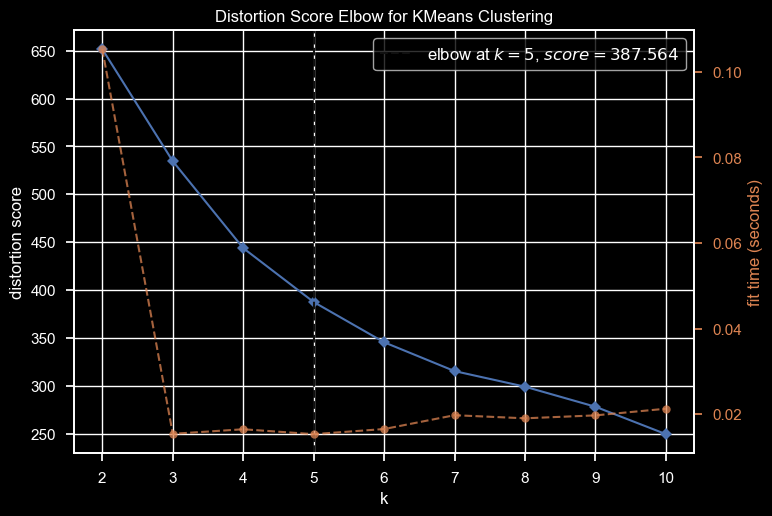

In [8]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

sns.set_theme(context='notebook', style=plt.style.use('dark_background'))

# Quick examination of elbow method to find numbers of clusters to make.
elbow_method = KElbowVisualizer(KMeans(), k=10)
elbow_method.fit(X_pca)
elbow_method.show();

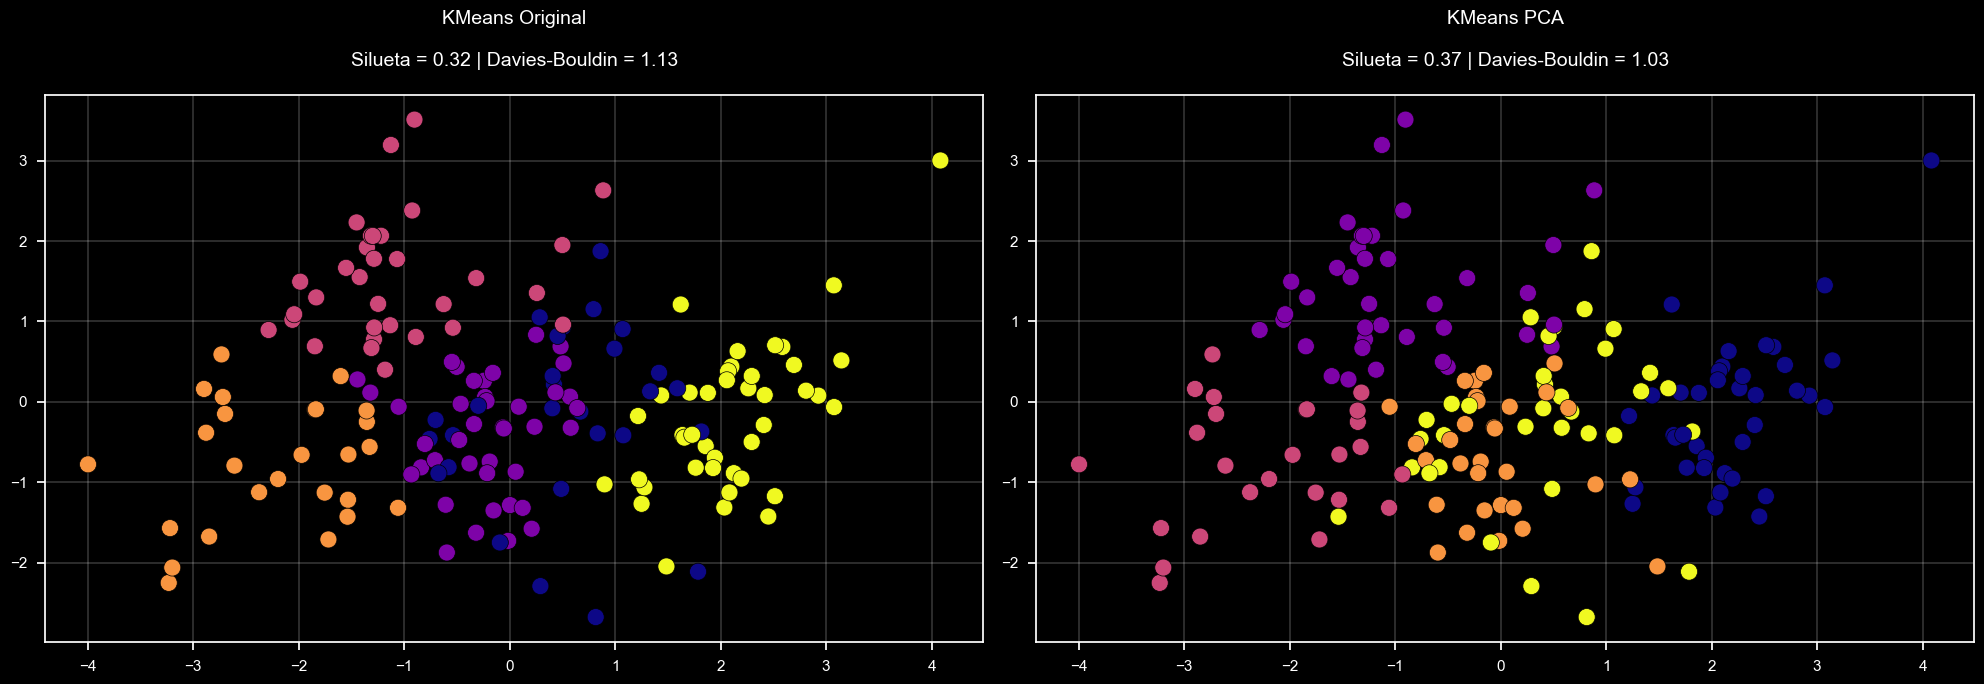

In [9]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Número de clusters y semilla para reproduciblidad
n_clusters = 5
seed = 25

# Crear un diccionario para almacenar los modelos
models = dict()

# Definir los datasets originales y transformados por PCA (X y X_pca)
datasets = [('Original', X), ('PCA', X_pca)]

for dataset_name, dataset in datasets:
    # Entrenar modelo K-Means
    model = KMeans(n_clusters=n_clusters,
                   max_iter=500,
                   init='k-means++',
                   random_state=seed)
    dataset['clusters'] = model.fit_predict(dataset)
    
    # Almacenar el modelo en el diccionario
    models[f'KMeans {dataset_name}'] = model
    
# Calcular métricas y graficar resultados para ambos modelos
fig, axes = plt.subplots(1, 2, figsize=(20, 7))  # 1 fila y 2 columnas para dos gráficos lado a lado
plt.set_cmap('plasma')

for i, (model_name, model) in enumerate(models.items()):
    dataset = X if 'original' in model_name else X_pca

    # Cálculo de métricas para K-Means
    silhouette_avg = silhouette_score(dataset, model.labels_)
    davies_bouldin = davies_bouldin_score(dataset, model.labels_)

    # Gráfica de clusters con K-Means
    ax = axes[i]
    ax.scatter(dataset.values[model.labels_ >= 0][:, 0], dataset.values[model.labels_ >= 0][:, 1],
               c=model.labels_[model.labels_ >= 0], s=150, linewidth=0.5, edgecolors='black')
    ax.set_title(f'{model_name}\n\nSilueta = {silhouette_avg:.2f} | Davies-Bouldin = {davies_bouldin:.2f}\n', fontsize=14)
    ax.grid(color='white', linestyle='-', linewidth=0.25)
    
plt.tight_layout()
plt.show()

In [10]:
def plot_kmeans_clusters(dataset:pd.DataFrame, max_clusters=10):
    
    fig = plt.figure(figsize=(26, 12))
    plt.suptitle('Rendimiento del KMeans con diferentes "K"', fontsize=18)

    for k in range(2, max_clusters):
        # Creación de clusters
        kmeans = KMeans(n_clusters=k, 
                        max_iter=500,
                        init='k-means++',
                        random_state=seed)
        kmeans.fit_predict(dataset)

        # Cálculo de métricas
        silhouette = silhouette_score(dataset, kmeans.labels_)
        davies_bouldin = davies_bouldin_score(dataset, kmeans.labels_)

        # Graficando clusters
        ax = fig.add_subplot(2, 4, k-1)
        ax.scatter(dataset.values[kmeans.labels_ >= 0][:, 0], dataset.values[kmeans.labels_ >= 0][:, 1], 
                   c=kmeans.labels_[kmeans.labels_ >= 0], s=100, 
                   linewidth=0.5, edgecolors='black', alpha=0.85)
        ax.set_title(f'K = {k}\nSilueta = {silhouette:.2f} \nDavies-Bouldin = {davies_bouldin:.2f}\n', fontsize=16)
        plt.grid(color='white', linestyle='-', linewidth=0.25)

    plt.tight_layout(pad=2.0)
    plt.show()

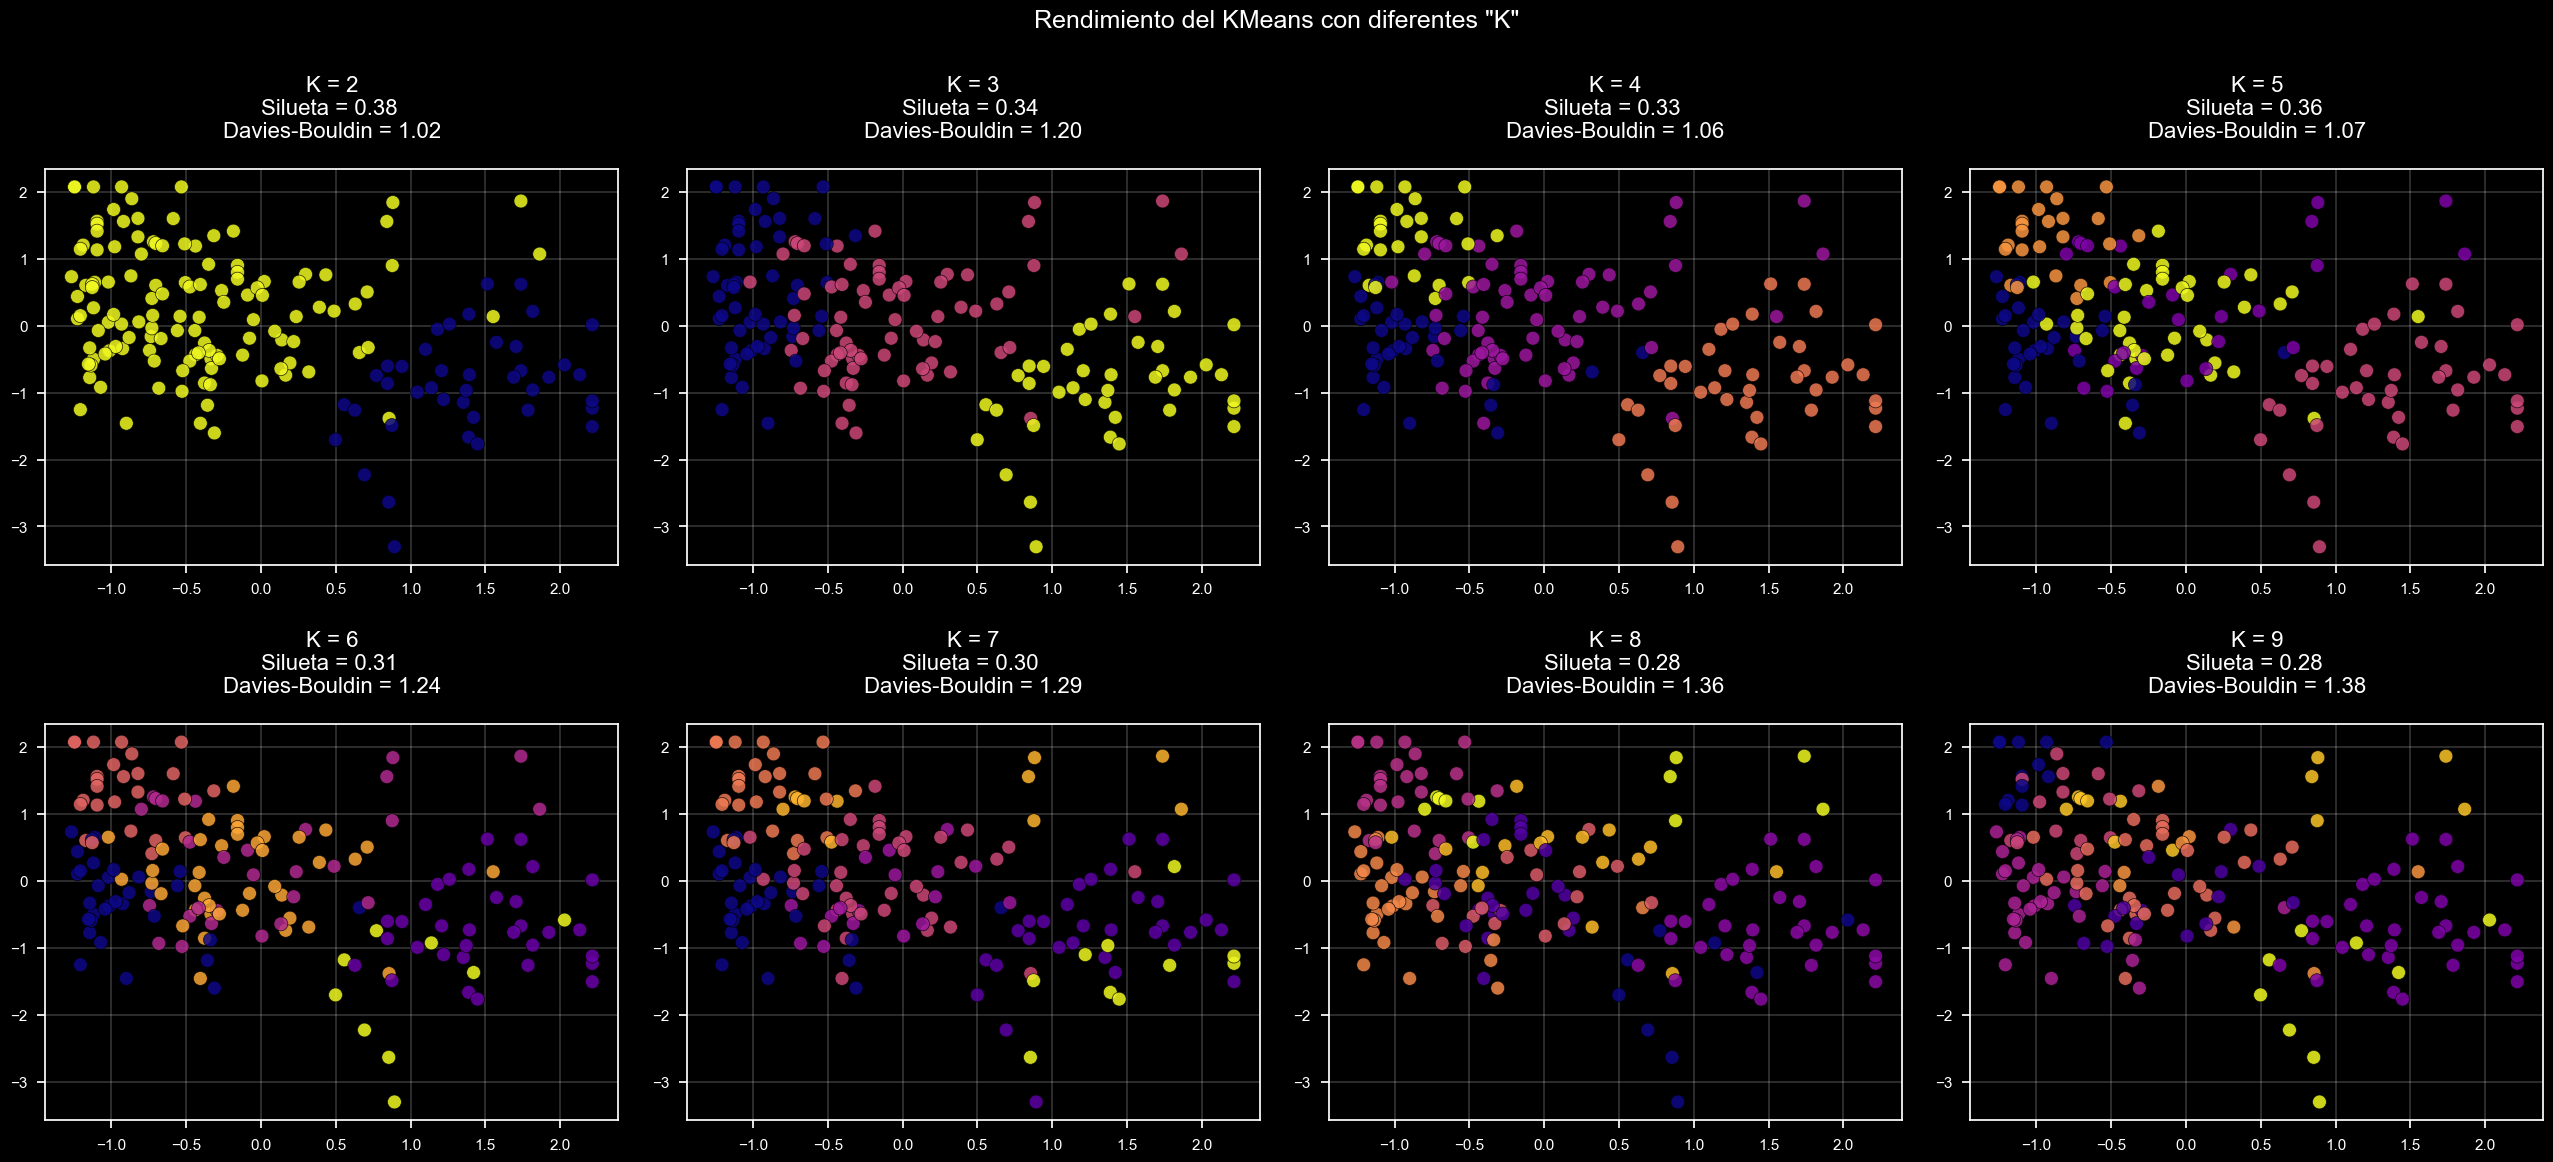

In [11]:
# Graficando los clusters utilizando todos los features
plot_kmeans_clusters(X)

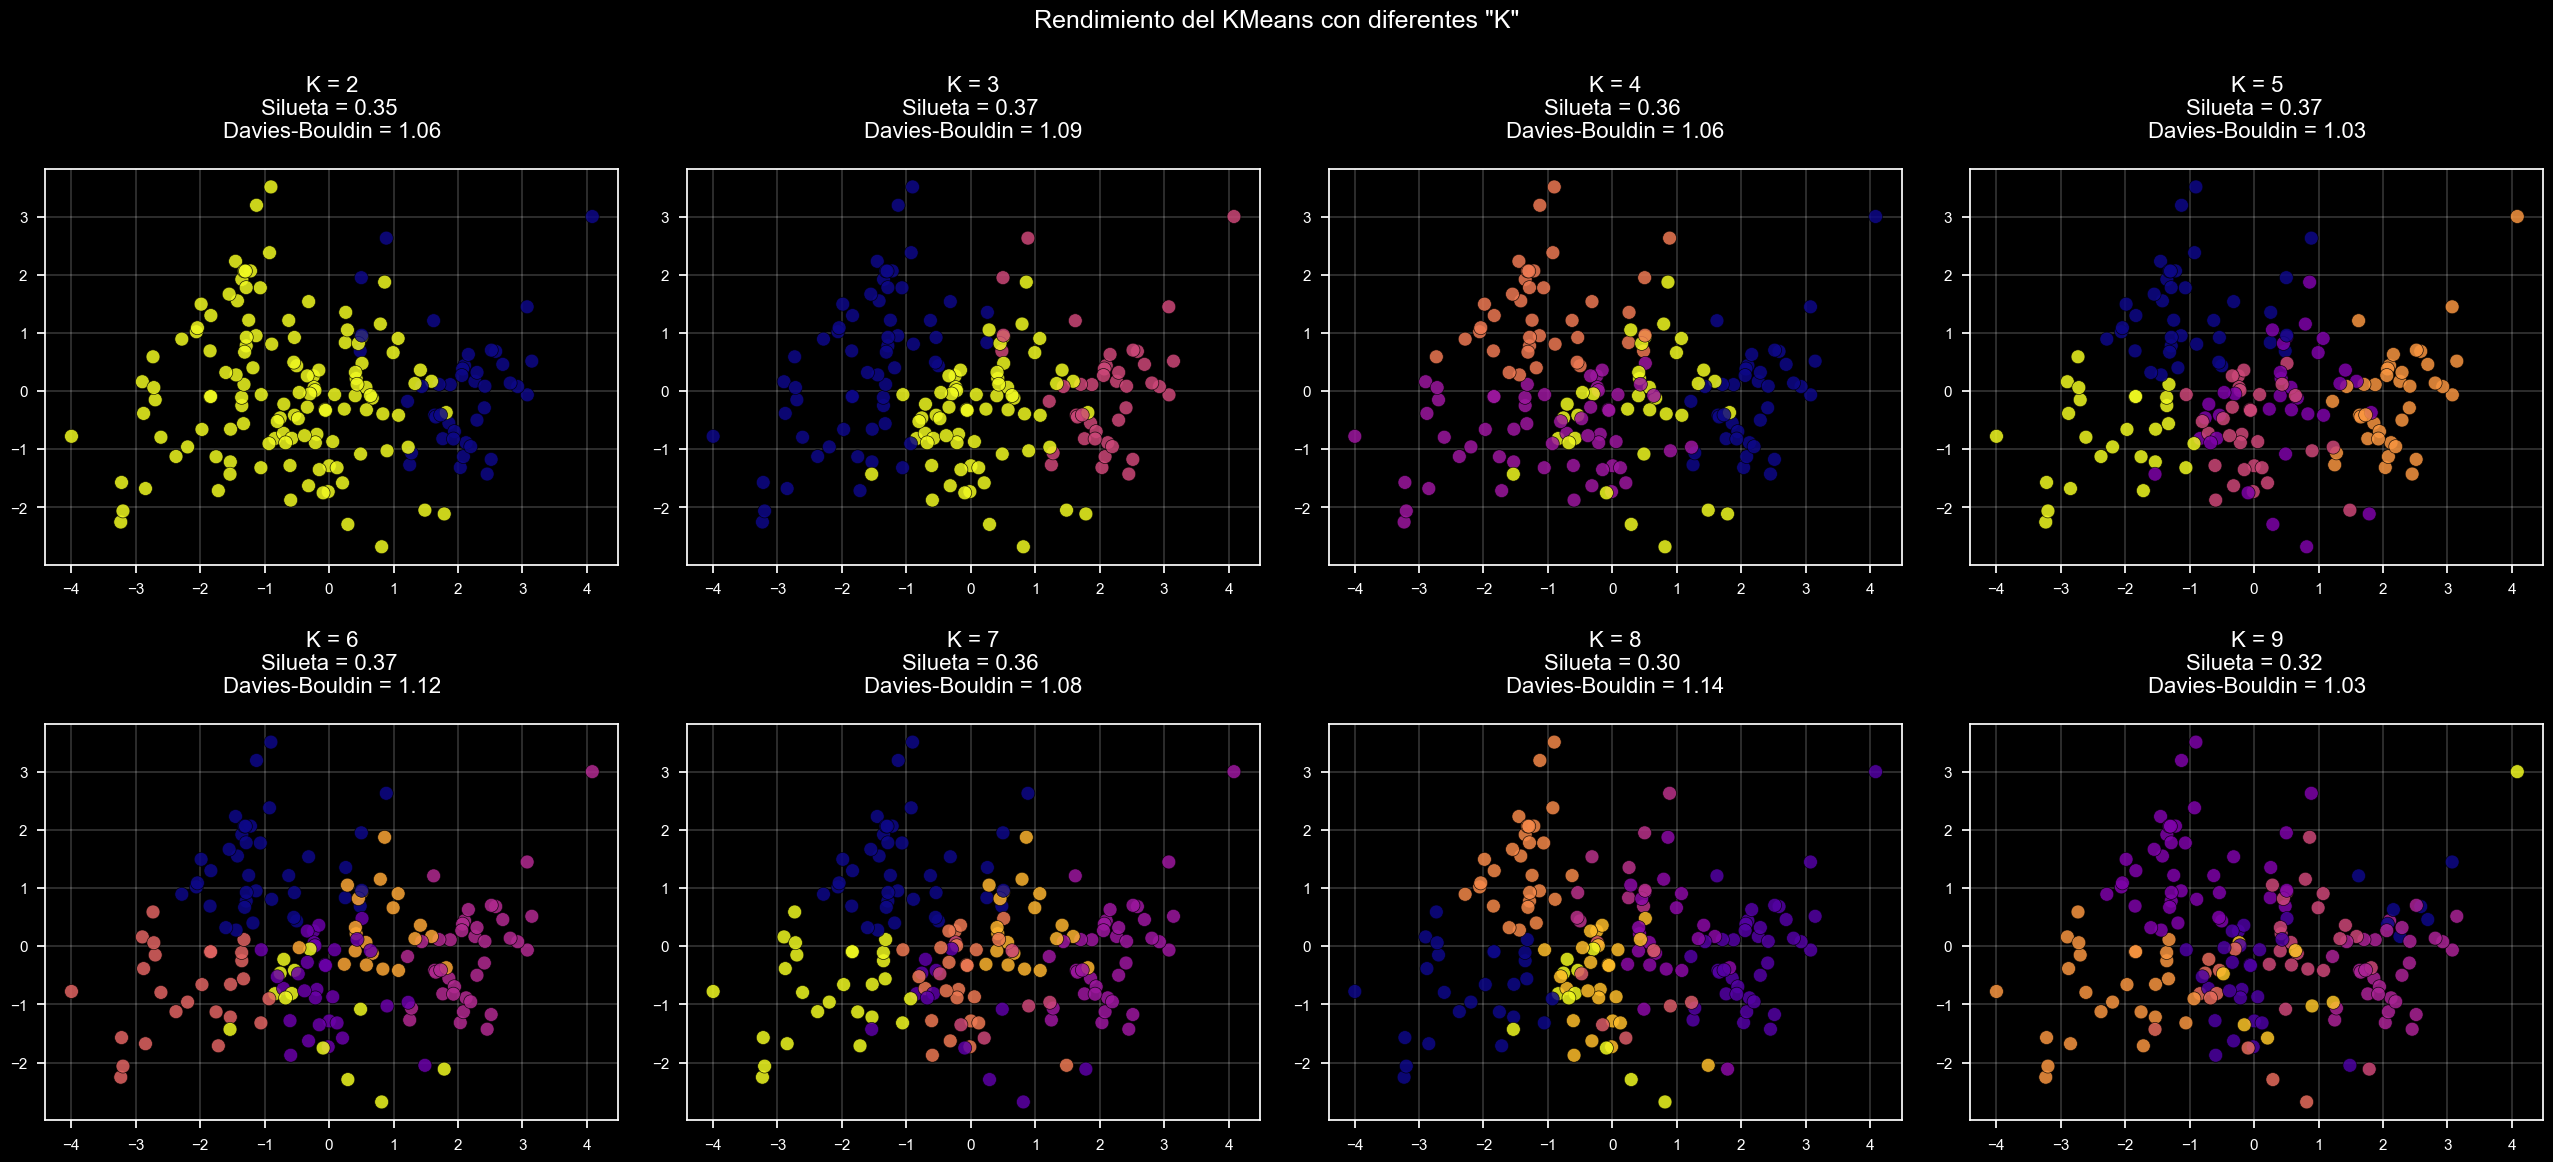

In [12]:
# Graficando los clusters utilizando PCA sobre los features
plot_kmeans_clusters(X_pca)

In [13]:
data_raw = pd.read_csv('../data/raw/Country-data.csv')
clustering = data_raw.merge(X_pca['clusters'].reset_index(), 
                            how='left', 
                            on='country')
clustering

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
0,Afghanistan,90.20,10.00,7.58,44.90,1610,9.44,56.20,5.82,553,0
1,Albania,16.60,28.00,6.55,48.60,9930,4.49,76.30,1.65,4090,3
2,Algeria,27.30,38.40,4.17,31.40,12900,16.10,76.50,2.89,4460,4
3,Angola,119.00,62.30,2.85,42.90,5900,22.40,60.10,6.16,3530,4
4,Antigua and Barbuda,10.30,45.50,6.03,58.90,19100,1.44,76.80,2.13,12200,2
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.20,46.60,5.25,52.70,2950,2.62,63.00,3.50,2970,3
163,Venezuela,17.10,28.50,4.91,17.60,16500,45.90,75.40,2.47,13500,4
164,Vietnam,23.30,72.00,6.84,80.20,4490,12.10,73.10,1.95,1310,3
165,Yemen,56.30,30.00,5.18,34.40,4480,23.60,67.50,4.67,1310,4


In [14]:
clusters_etiquetados = clustering.groupby('clusters')[['gdpp', 'exports', 'imports', 'health', 'inflation', 'life_expec', 'child_mort']].mean().sort_values(by='gdpp', ascending=False)
clusters_etiquetados.rename(index={1: 'Desarrollados',
                                   2: 'En desarollo avanzado',
                                   4: 'En desarrollo intermedio',
                                   3: 'Menos desarrollados',
                                   0: 'Subdesarrollados'}, inplace=True)
clusters_etiquetados

,gdpp,exports,imports,health,inflation,life_expec,child_mort
clusters,,,,,,,
Desarrollados,"27,095.79",31.64,34.48,9.27,2.85,77.99,9.80
En desarollo avanzado,"24,360.38",80.05,77.03,7.12,1.46,77.24,8.29
En desarrollo intermedio,"11,207.06",45.86,34.79,4.45,15.80,71.35,31.20
Menos desarrollados,"2,826.16",39.74,63.78,7.28,5.65,67.93,37.21
Subdesarrollados,877.71,20.80,35.73,5.89,11.60,59.98,94.44


In [ ]:
import joblib

joblib.dump(models['KMeans PCA'], '../models/model.pkl')
clustering.to_csv('../models/clustering.csv', index=False)

---
---